In [1]:
import pandas as pd
from csv import DictReader
import obonet
import networkx as nx
import numpy as np
import argparse
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from tqdm import tqdm
from pathlib import Path


In [2]:
def get_gene_df():
    gene2hpo = {}
    alt_id = {}
    graph = obonet.read_obo(
        "https://raw.githubusercontent.com/obophenotype/human-phenotype-ontology/master/hp.obo"
    )
    for id_, node in graph.nodes(data=True):
            for alt in node.get('alt_id', []):
                alt_id[alt] = id_
    
    associations_url = "http://purl.obolibrary.org/obo/hp/hpoa/genes_to_phenotype.txt"
    associations = pd.read_csv(associations_url, sep='\t')
    associations = associations[['gene_symbol','hpo_id']]

    gene2hpo = dict()
    for ind in associations.index:
      gene_name = associations["gene_symbol"][ind]
      hp_term = associations["hpo_id"][ind]
      if gene_name not in gene2hpo:
          gene2hpo[gene_name] = list([])
      gene2hpo[gene_name].append(hp_term)
    #gene2hpo[gene_name] = gene2hpo[gene_name] + list(nx.neighbors(graph, hp_term))
    gene2hpo[gene_name] = gene2hpo[gene_name] + list(nx.predecessor(graph, hp_term))
    #gene2hpo[gene_name] = gene2hpo[gene_name] + list(graph.predecessors(hp_term)) + list(graph.successors(hp_term))
    gene2hpo[gene_name] = list(
        dict.fromkeys(gene2hpo[gene_name])
    )  # check for duplicate values and drop them
    gene2hpo[gene_name] = list(
        filter(None, gene2hpo[gene_name])
    )  # check for null values and drop them
    # gene2hpo[gene_name] = comparison.parse_terms(gene2hpo[gene_name])

    gene2hpo = {"Genes": list(gene2hpo.keys()), "HPOs": list(gene2hpo.values())}
    gene2hpo = pd.DataFrame(gene2hpo)
    return gene2hpo, graph, alt_id


In [3]:
def parse_terms(alt_terms, in_terms):
        """ This function parses through terms that are provided, then it returns a new list with updated HPO terms. """
        new_terms = []
        for term in in_terms:
            if term in list(alt_terms.keys()):
                new_terms.append(alt_terms[term])
            else:
                new_terms.append(term)
        return new_terms


In [4]:
print("Generating Gene-Phene vectors from HPO...")
gene_2_hpo, graph, alt_id = get_gene_df()
print("done!")


Generating Gene-Phene vectors from HPO...
done!


In [5]:
import json

# Specify the path to your JSON file
file_path = '../../data/external/train_test_metadata_nonGeneticHPOsRemoved.json'

# Open the JSON file for reading
with open(file_path, 'r') as json_file:
    # Use json.load() to parse the JSON data from the file
    metadata = json.load(json_file)
    


In [12]:
# Filter the dictionary to keep only dictionaries containing "pro" in keys or values
probands = {key: subdict for key, subdict in { **metadata['test']}.items() if 'PROBAND' in key}
# probands = {key: subdict for key, subdict in {**metadata['train'], **metadata['test']}.items() if 'PROBAND' in key}
probands.keys()


dict_keys(['CAGI6_RGP_TEST_1_PROBAND', 'CAGI6_RGP_TEST_2_PROBAND', 'CAGI6_RGP_TEST_3_PROBAND', 'CAGI6_RGP_TEST_4_PROBAND', 'CAGI6_RGP_TEST_5_PROBAND', 'CAGI6_RGP_TEST_6_PROBAND', 'CAGI6_RGP_TEST_7_PROBAND', 'CAGI6_RGP_TEST_8_PROBAND', 'CAGI6_RGP_TEST_9_PROBAND', 'CAGI6_RGP_TEST_10_PROBAND', 'CAGI6_RGP_TEST_11_PROBAND', 'CAGI6_RGP_TEST_12_PROBAND', 'CAGI6_RGP_TEST_13_PROBAND', 'CAGI6_RGP_TEST_14_PROBAND', 'CAGI6_RGP_TEST_15_PROBAND', 'CAGI6_RGP_TEST_16_PROBAND', 'CAGI6_RGP_TEST_17_PROBAND', 'CAGI6_RGP_TEST_18_PROBAND', 'CAGI6_RGP_TEST_19_PROBAND', 'CAGI6_RGP_TEST_20_PROBAND', 'CAGI6_RGP_TEST_21_PROBAND', 'CAGI6_RGP_TEST_22_PROBAND', 'CAGI6_RGP_TEST_23_PROBAND', 'CAGI6_RGP_TEST_24_PROBAND', 'CAGI6_RGP_TEST_25_PROBAND', 'CAGI6_RGP_TEST_26_PROBAND', 'CAGI6_RGP_TEST_27_PROBAND', 'CAGI6_RGP_TEST_28_PROBAND', 'CAGI6_RGP_TEST_29_PROBAND', 'CAGI6_RGP_TEST_30_PROBAND'])

In [10]:
probands['CAGI6_RGP_TRAIN_4_PROBAND']

{'sex': 'Female',
 'affected_status': 'Affected',
 'hpo': {'HP:0000510': 'Rod-cone dystrophy', 'HP:0000618': 'Blindness'},
 'solves': [{'Gene': 'CNGB1',
   'Zygosity': 'Homozygous',
   'Chrom': 16,
   'Pos': 57901371,
   'Ref': 'T',
   'Alt': 'A',
   'hgvsc': 'c.2957A>T',
   'hgvsp': 'p.Asn986Ile',
   'Transcript': 'ENST00000251102'}]}

In [51]:
probands['CAGI6_RGP_TRAIN_3_PROBAND']['hpo'].keys()

dict_keys(['HP:0002020', 'HP:0008738', 'HP:0000218', 'HP:0009747', 'HP:0100814', 'HP:0001773', 'HP:0200055', 'HP:0003128', 'HP:0002046', 'HP:0001252', 'HP:0012758', 'HP:0000707', 'HP:0001250', 'HP:0100547', 'HP:0007359', 'HP:0000326', 'HP:0000076'])

In [7]:
probands['CAGI6_RGP_TEST_2_PROBAND']

{'sex': 'Female',
 'affected_status': 'Affected',
 'hpo': {'HP:0001738': 'Exocrine pancreatic insufficiency',
  'HP:0200035': 'Skin plaque',
  'HP:0001324': 'Muscle weakness',
  'HP:0005750': 'Contractures of the joints of the lower limbs',
  'HP:0002206': 'Pulmonary fibrosis'}}

In [24]:
input_phenotypes = list(probands['CAGI6_RGP_TEST_27_PROBAND']['hpo'].keys())
#input_phenotypes =['HP:0002020', 'HP:0008738', 'HP:0000218', 'HP:0009747', 'HP:0100814', 'HP:0001773', 'HP:0200055', 'HP:0003128', 'HP:0001252', 'HP:0012758', 'HP:0000707', 'HP:0001250', 'HP:0100547', 'HP:0007359', 'HP:0000326', 'HP:0000076']
input_phenotypes = parse_terms(alt_id, input_phenotypes)
input_phenotypes = list(dict.fromkeys(input_phenotypes))  # check for duplicate values and drop them
term_len = len(input_phenotypes)
ranked_genes = gene_2_hpo
ranked_genes["score"] = [
            (len(list(set(input_phenotypes) & set(i)))) / term_len for i in ranked_genes["HPOs"].values
        ]
ranked_genes = (
ranked_genes[["Genes", "score"]]
            .sort_values(by="score", ascending=False)
            .reset_index(drop=True)
            )
ranked_genes

,Genes,score
0,CCNO,1.0
1,STK36,1.0
2,BTG4,1.0
3,FIGLA,1.0
4,HYDIN,1.0
...,...,...
5002,PLS1,0.0
5003,PLP1,0.0
5004,PLOD2,0.0
5005,PLOD1,0.0


In [30]:
ranked_genes[ranked_genes['Genes']=='FRY']

,Genes,score


In [12]:
p1 = pd.read_csv('../../data/external/CAGI_TR/CAGI6_RGP_TRAIN_4_PROBAND_DITTO_scores.csv.gz')
p1 = p1.sort_values(by="DITTO", ascending=False).drop_duplicates(subset=['chrom', 'pos', 'ref_base', 'alt_base'], keep='first').reset_index(drop=True)
p1.head()

/var/folders/x5/1jk7xryd0rg4d710y586kmvh0000gp/T/ipykernel_63690/220700554.py:1: DtypeWarning: Columns (3,4,9,10,12,13,14,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  p1 = pd.read_csv('../../data/external/CAGI_TR/CAGI6_RGP_TRAIN_4_PROBAND_DITTO_scores.csv.gz')


,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,clinvar.id,clinvar.sig,clinvar.rev_stat,clinvar.sig_conf,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,gnomad3.af,DITTO
0,NaN,NaN,NaN,NaN,NaN,chrY,11344982,T,A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs373109292,NaN,1.0
1,ENST00000346753,TMPRSS6,missense_variant,p.Ser762Pro,c.2284T>C,chr22,37066232,A,G,NaN,...,NaN,NaN,NaN,NaN,164656.0,NaN,Q8IU80,rs989136361,0.000014,1.0
2,ENST00000370971,WLS,"exon_loss_variant,frameshift_truncation",p.Ala36fs,c.107-5775_107-5769del,chr1,68199996,TAAAGAA,-,NaN,...,NaN,NaN,NaN,NaN,79971.0,NaN,Q5T9L3,rs1233200627,0.000021,1.0
3,NaN,NaN,NaN,NaN,NaN,chrY,11336356,G,T,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1183603554,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,chrY,11337041,C,T,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1243418603,NaN,1.0


In [15]:
p_var = "p.Asn986Ile"

In [90]:
p1[p1['protein_hgvs']==p_var]

,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,clinvar.id,clinvar.sig,clinvar.rev_stat,clinvar.sig_conf,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,gnomad3.af,DITTO
27420,ENST00000251102,CNGB1,missense_variant,p.Asn986Ile,c.2957A>T,chr16,57901371,T,A,NaN,...,166891.0,Conflicting interpretations of pathogenicity,"criteria provided, conflicting interpretations",Pathogenic(7)|Likely pathogenic(2)|Uncertain s...,1258.0,268000,Q14028,rs201162411,0.001131,0.010933


In [91]:
merged = p1.merge(ranked_genes, left_on='gene', right_on = 'Genes', how='left').sort_values(by="score", ascending=False).reset_index(drop=True)
# merged['combined'] = merged['DITTO'] + merged['score']
# merged = merged.sort_values(by="combined", ascending=False).reset_index(drop=True)
merged[merged['protein_hgvs']==p_var]

,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,clinvar.rev_stat,clinvar.sig_conf,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,gnomad3.af,DITTO,Genes,score
11539,ENST00000251102,CNGB1,missense_variant,p.Asn986Ile,c.2957A>T,chr16,57901371,T,A,NaN,...,"criteria provided, conflicting interpretations",Pathogenic(7)|Likely pathogenic(2)|Uncertain s...,1258.0,268000,Q14028,rs201162411,0.001131,0.010933,CNGB1,1.0


In [92]:
merged = p1.merge(ranked_genes, left_on='gene', right_on = 'Genes', how='left').sort_values(by="DITTO", ascending=False).reset_index(drop=True)
# merged['combined'] = merged['DITTO'] + merged['score']
# merged = merged.sort_values(by="combined", ascending=False).reset_index(drop=True)
merged[merged['protein_hgvs']==p_var]

,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,clinvar.rev_stat,clinvar.sig_conf,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,gnomad3.af,DITTO,Genes,score
27420,ENST00000251102,CNGB1,missense_variant,p.Asn986Ile,c.2957A>T,chr16,57901371,T,A,NaN,...,"criteria provided, conflicting interpretations",Pathogenic(7)|Likely pathogenic(2)|Uncertain s...,1258.0,268000,Q14028,rs201162411,0.001131,0.010933,CNGB1,1.0


In [16]:
merged = p1.merge(ranked_genes, left_on='gene', right_on = 'Genes', how='left')
merged['combined'] = merged['DITTO'] + merged['score']
merged = merged.sort_values(by="combined", ascending=False).reset_index(drop=True)
merged[merged['protein_hgvs']==p_var]

,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,clinvar.sig_conf,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,gnomad3.af,DITTO,Genes,score,combined
75,ENST00000251102,CNGB1,missense_variant,p.Asn986Ile,c.2957A>T,chr16,57901371,T,A,NaN,...,Pathogenic(7)|Likely pathogenic(2)|Uncertain s...,1258.0,268000,Q14028,rs201162411,0.001131,0.010933,CNGB1,1.0,1.010933


In [17]:
merged[merged['gene']=='CNGB1']

,transcript,gene,consequence,protein_hgvs,cdna_hgvs,chrom,pos,ref_base,alt_base,clingen.disease,...,clinvar.sig_conf,ncbigene.entrez,omim.omim_id,uniprot.acc,dbsnp.rsid,gnomad3.af,DITTO,Genes,score,combined
75,ENST00000251102,CNGB1,missense_variant,p.Asn986Ile,c.2957A>T,chr16,57901371,T,A,NaN,...,Pathogenic(7)|Likely pathogenic(2)|Uncertain s...,1258.0,268000,Q14028,rs201162411,0.001131,0.010933,CNGB1,1.0,1.010933
105,ENST00000311183,CNGB1,intron_variant,NaN,c.874+947T>C,chr16,57956394,A,G,NaN,...,NaN,1258.0,NaN,Q14028,rs1472628652,0.000363,0.003504,CNGB1,1.0,1.003504
122,ENST00000251102,CNGB1,intron_variant,NaN,c.3243-4001_3243-3999dup,chr16,57892073,-,AAA,NaN,...,NaN,1258.0,NaN,Q14028,NaN,0.001582,0.002355,CNGB1,1.0,1.002355
130,ENST00000251102,CNGB1,intron_variant,NaN,c.2492+264T>C,chr16,57911489,A,G,NaN,...,NaN,1258.0,NaN,Q14028,rs1269478020,0.000042,0.001910,CNGB1,1.0,1.001910
230,ENST00000251102,CNGB1,intron_variant,NaN,c.1373-1170G>T,chr16,57933048,C,A,NaN,...,NaN,1258.0,NaN,Q14028,rs533577976,0.002645,0.000337,CNGB1,1.0,1.000337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,ENST00000251102,CNGB1,intron_variant,NaN,c.2976+1705_2976+1708dup,chr16,57899644,-,AAAC,NaN,...,NaN,1258.0,NaN,Q14028,NaN,0.063971,0.000000,CNGB1,1.0,1.000000
781,ENST00000251102,CNGB1,intron_variant,NaN,c.2976+1485A>G,chr16,57899867,T,C,NaN,...,NaN,1258.0,NaN,Q14028,rs17240980,0.064532,0.000000,CNGB1,1.0,1.000000
782,ENST00000251102,CNGB1,intron_variant,NaN,c.2976+292del,chr16,57901060,G,-,NaN,...,NaN,1258.0,NaN,Q14028,NaN,0.835309,0.000000,CNGB1,1.0,1.000000
783,ENST00000251102,CNGB1,intron_variant,NaN,c.2976+171A>G,chr16,57901181,T,C,NaN,...,NaN,1258.0,NaN,Q14028,rs190319,0.851679,0.000000,CNGB1,1.0,1.000000


In [ ]:
merged.columns

Index(['transcript', 'gene', 'consequence', 'protein_hgvs', 'cdna_hgvs',
       'chrom', 'pos', 'ref_base', 'alt_base', 'clingen.disease',
       'clingen.classification', 'clinvar.id', 'clinvar.sig',
       'clinvar.rev_stat', 'clinvar.sig_conf', 'ncbigene.entrez',
       'omim.omim_id', 'uniprot.acc', 'dbsnp.rsid', 'gnomad3.af', 'DITTO',
       'Genes', 'score', 'combined'],
      dtype='object')

In [18]:
merged[['chrom', 'pos', 'ref_base', 'alt_base','protein_hgvs','consequence','clinvar.sig','clingen.disease','clingen.classification',
       'Genes', 'score','gnomad3.af', 'DITTO', 'combined']].head(80)

,chrom,pos,ref_base,alt_base,protein_hgvs,consequence,clinvar.sig,clingen.disease,clingen.classification,Genes,score,gnomad3.af,DITTO,combined
0,chr11,66514481,G,A,p.Arg67Gln,"missense_variant,NMD_transcript_variant",Uncertain significance,NaN,NaN,BBS1,1.0,0.001130,1.000000,2.000000
1,chr4,16000517,G,T,p.Tyr519Ter,stop_gained,Pathogenic,NaN,NaN,PROM1,1.0,0.000084,1.000000,2.000000
2,chr19,1240771,CCG,-,NaN,2kb_upstream_variant,NaN,NaN,NaN,ATP5F1D,1.0,0.001839,1.000000,2.000000
3,chr16,56499773,C,G,NaN,"2kb_downstream_variant,processed_transcript",Uncertain significance,NaN,NaN,BBS2,1.0,0.000056,0.999999,1.999999
4,chr18,46098363,-,ACC,NaN,2kb_upstream_variant,NaN,NaN,NaN,ATP5F1A,1.0,0.001305,0.960523,1.960523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,chr16,57901371,T,A,p.Asn986Ile,missense_variant,Conflicting interpretations of pathogenicity,NaN,NaN,CNGB1,1.0,0.001131,0.010933,1.010933
76,chr2,181629320,A,T,NaN,intron_variant,NaN,NaN,NaN,CERKL,1.0,0.000056,0.010234,1.010234
77,chr6,63816590,C,T,NaN,intron_variant,NaN,NaN,NaN,EYS,1.0,0.000942,0.010150,1.010150
78,chr6,65491269,-,AC,NaN,intron_variant,NaN,NaN,NaN,EYS,1.0,0.021479,0.009472,1.009472


In [20]:
merged['clinvar.sig'].unique()

array(['Uncertain significance', 'Pathogenic', nan, 'Likely benign',
       'Conflicting interpretations of pathogenicity', 'Benign',
       'Benign/Likely benign', 'Likely pathogenic',
       'Uncertain risk allele', 'Benign|protective',
       'Uncertain significance|association', 'Benign|other',
       'risk factor', 'drug response', 'not provided', 'association',
       'Affects|association', 'protective', 'Affects', 'other',
       'Conflicting interpretations of pathogenicity|other|risk factor',
       'Likely risk allele', 'association|drug response|risk factor',
       'association|drug response', 'Pathogenic/Likely pathogenic|other',
       'Conflicting interpretations of pathogenicity|other',
       'Benign|drug response', 'Benign|risk factor',
       'confers sensitivity', 'protective|risk factor',
       'Benign|confers sensitivity', 'Uncertain risk allele|risk factor',
       'Pathogenic|risk factor',
       'Conflicting interpretations of pathogenicity|protective',
      

In [33]:
merged.loc[(merged['clinvar.sig'].isin(['Likely pathogenic', 'Pathogenic', 'Pathogenic/Likely pathogenic','risk factor', 'drug response','Likely risk allele', 'association|drug response|risk factor', 'association|drug response', 'Pathogenic/Likely pathogenic|other','protective|risk factor', 'Pathogenic|risk factor'])) & (merged['combined']>=0.9)][['chrom', 'pos', 'ref_base', 'alt_base','protein_hgvs','consequence','clinvar.sig','clingen.disease','clingen.classification','Genes', 'score','gnomad3.af', 'DITTO', 'combined']]

,chrom,pos,ref_base,alt_base,protein_hgvs,consequence,clinvar.sig,clingen.disease,clingen.classification,Genes,score,gnomad3.af,DITTO,combined
1,chr4,16000517,G,T,p.Tyr519Ter,stop_gained,Pathogenic,NaN,NaN,PROM1,1.0,0.000084,1.0,2.0
8557,chr10,104037044,C,T,NaN,"intron_variant,splice_site_variant",Likely pathogenic,NaN,NaN,COL17A1,0.0,0.000098,1.0,1.0


In [12]:
rank_list = {}
with open('../data/testing/probe_info') as fp:
    for line in tqdm(fp):
        line_values = line.strip().split('\t')
        if Path(f'../data/testing/{line_values[0]}/{line_values[1]}').is_file():
            if line_values[0] not in rank_list:
                ranked_genes = gene_2_hpo
                rank_list[line_values[0]] = []
            input_phenotypes = []
            with open(f'../data/testing/{line_values[0]}/{line_values[1]}') as fp:
                for line in fp:
                    input_phenotypes.append(line.strip())
        else:
            continue

        try:
            input_phenotypes = parse_terms(alt_id, input_phenotypes)
            input_phenotypes = list(dict.fromkeys(input_phenotypes))  # check for duplicate values and drop them

            term_len = len(input_phenotypes)
            ranked_genes["score"] = [
            (len(list(set(input_phenotypes) & set(i)))) / term_len for i in ranked_genes["HPOs"].values
        ]
            ranked_genes = (
            ranked_genes[["Genes", "score"]]
            .sort_values(by="score", ascending=False)
            .reset_index(drop=True)
            )
            
            ranked_genes = ranked_genes.drop_duplicates()
            rank_list[line_values[0]].append(ranked_genes.index[ranked_genes['Genes'] == line_values[2]].values[0]+1)
        except:
            rank_list[line_values[0]].append(np.nan)

rank_list = pd.DataFrame.from_dict(rank_list,orient='index').transpose()

282it [00:00, 384.28it/s]


In [13]:
rank_list

,Columbia_U,CSH,AJHG,DGD
0,774.0,250.0,8.0,61.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
80,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN


In [14]:
summary = {}
summary[f"Columbia_U"] = [len(rank_list[rank_list["Columbia_U"]==1]),len(rank_list[rank_list["Columbia_U"]<6]),len(rank_list[rank_list["Columbia_U"]<11]),len(rank_list[rank_list["Columbia_U"]<21]),len(rank_list[rank_list["Columbia_U"]<51]),len(rank_list[rank_list["Columbia_U"]<101]),len(rank_list[rank_list["Columbia_U"]<201])]
summary[f"CSH"] = [len(rank_list[rank_list["CSH"]==1]),len(rank_list[rank_list["CSH"]<6]),len(rank_list[rank_list["CSH"]<11]),len(rank_list[rank_list["CSH"]<21]),len(rank_list[rank_list["CSH"]<51]),len(rank_list[rank_list["CSH"]<101]),len(rank_list[rank_list["CSH"]<201])]
summary[f"AJHG"] = [len(rank_list[rank_list["AJHG"]==1]),len(rank_list[rank_list["AJHG"]<6]),len(rank_list[rank_list["AJHG"]<11]),len(rank_list[rank_list["AJHG"]<21]),len(rank_list[rank_list["AJHG"]<51]),len(rank_list[rank_list["AJHG"]<101]),len(rank_list[rank_list["AJHG"]<201])]
summary[f"DGD"] = [len(rank_list[rank_list["DGD"]==1]),len(rank_list[rank_list["DGD"]<6]),len(rank_list[rank_list["DGD"]<11]),len(rank_list[rank_list["DGD"]<21]),len(rank_list[rank_list["DGD"]<51]),len(rank_list[rank_list["DGD"]<101]),len(rank_list[rank_list["DGD"]<201])]

summary1 = pd.DataFrame(summary, index=['Top-1', 'Top-5',
       'Top-10', 'Top-20', 'Top-50',
       'Top-100', 'Top-200'])

summary1

,Columbia_U,CSH,AJHG,DGD
Top-1,0,0,0,0
Top-5,0,0,0,0
Top-10,0,0,1,0
Top-20,0,0,1,0
Top-50,0,0,1,0
Top-100,0,0,1,1
Top-200,0,0,1,1


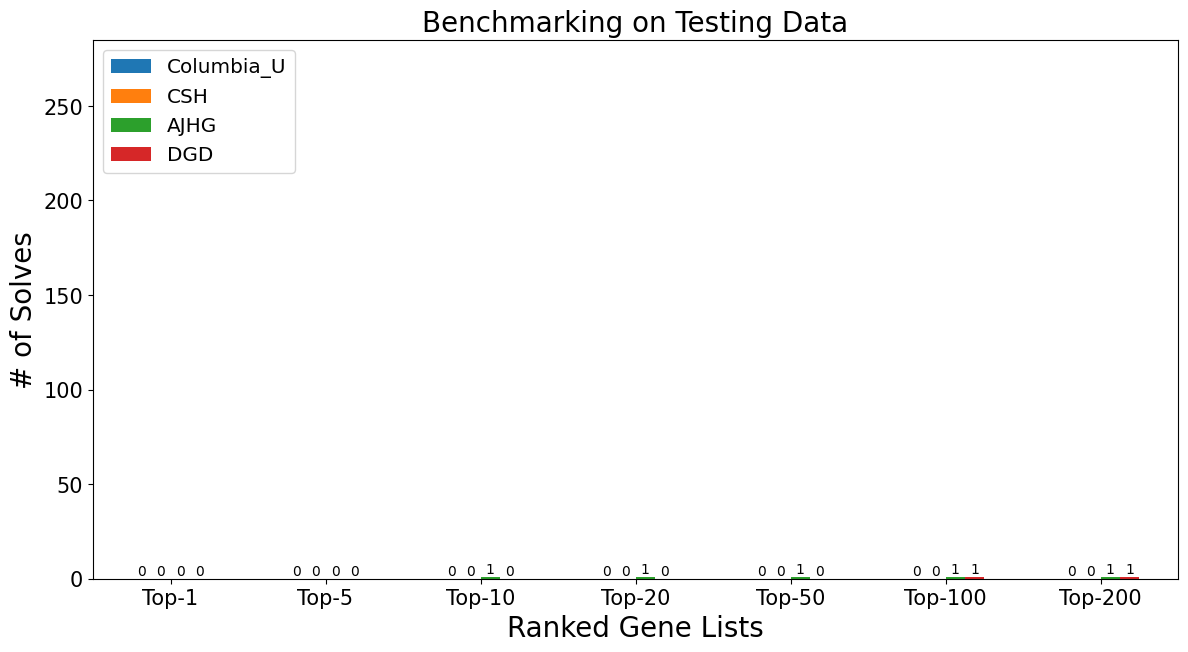

In [15]:
ax = summary1.plot.bar(figsize=(14, 7))
#plt.legend(fontsize=12) # using a size in points
plt.legend(fontsize="x-large", loc='upper left') # using a named size
plt.xticks(fontsize = 15)
plt.tick_params(axis="x", rotation=0)
plt.yticks(fontsize = 15)
plt.ylim(0, 285)
plt.title("Benchmarking on Testing Data",
          fontsize = 20)

plt.xlabel("Ranked Gene Lists",
          fontsize = 20)

plt.ylabel("# of Solves",
          fontsize = 20)
for container in ax.containers:
    ax.bar_label(container)